<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/ADMM/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!rm -rfv synthetic_data/;
! rm -rfv *.png, cuda.cu, metrics_log.csv, training_log.csv;

removed 'synthetic_data/node_1_scaling.csv'
removed 'synthetic_data/node_3_features.csv'
removed 'synthetic_data/node_4_labels.csv'
removed 'synthetic_data/node_0_scaling.csv'
removed 'synthetic_data/node_4_features.csv'
removed 'synthetic_data/node_2_scaling.csv'
removed 'synthetic_data/node_2_features.csv'
removed 'synthetic_data/node_1_features.csv'
removed 'synthetic_data/node_1_labels.csv'
removed 'synthetic_data/node_3_scaling.csv'
removed 'synthetic_data/node_3_labels.csv'
removed 'synthetic_data/node_0_features.csv'
removed 'synthetic_data/node_2_labels.csv'
removed 'synthetic_data/node_0_labels.csv'
removed 'synthetic_data/node_4_scaling.csv'
removed directory 'synthetic_data/'


In [110]:
import numpy as np
import pandas as pd
import os

np.random.seed(42)  # for reproducibility

num_nodes = 5
num_samples_per_node = 1000
num_features = 5

os.makedirs("synthetic_data", exist_ok=True)

exchange_rates = np.random.uniform(0.5, 2.0, size=(num_nodes, num_features))
global_weights = np.random.randn(num_features)

for node_id in range(num_nodes):
    w_i = exchange_rates[node_id]
    A_raw = np.random.randn(num_samples_per_node, num_features)
    A_scaled = A_raw * w_i

    logits = A_scaled @ global_weights
    logits *= 10  # sharpens sigmoid step

    probs = 1 / (1 + np.exp(-logits))
    b = np.random.binomial(1, probs)

    df_features = pd.DataFrame(A_scaled)
    df_features.to_csv(f"synthetic_data/node_{node_id}_features.csv", index=False, header=False)

    df_labels = pd.DataFrame(b)
    df_labels.to_csv(f"synthetic_data/node_{node_id}_labels.csv", index=False, header=False)

    df_rates = pd.DataFrame([w_i])
    df_rates.to_csv(f"synthetic_data/node_{node_id}_scaling.csv", index=False, header=False)

print(f"Synthetic data for {num_nodes} nodes saved in 'synthetic_data/' directory.")


Synthetic data for 5 nodes saved in 'synthetic_data/' directory.


In [111]:
%%writefile cuda.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda.h>
#include <math.h>

#define FEATURES 5
#define SAMPLES 1000
#define MAX_ITER 4000
#define STEP_SIZE 0.0005f
#define RHO 0.01f
#define REPORT_EVERY 500
#define NODES 5

__global__ void xi_update_kernel_vectorized(
    float* A, float* b, float* x, float* z, float* lambda,
    float* gradient_accum, int samples, int features
) {
    int sample_idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (sample_idx < samples) {
        float dot = 0.0f;
        for (int j = 0; j < features; j++)
            dot += A[sample_idx * features + j] * x[j];

        float y_hat = 1.0f / (1.0f + expf(-dot));
        float coeff = y_hat - b[sample_idx];

        for (int j = 0; j < features; j++) {
            float partial = A[sample_idx * features + j] * coeff / samples;
            atomicAdd(&gradient_accum[j], partial);
        }
    }
}

void read_csv(const char* filename, float* data, int rows, int cols) {
    FILE* f = fopen(filename, "r");
    if (!f) {
        printf("Cannot open %s\n", filename);
        exit(1);
    }
    for (int i = 0; i < rows * cols; i++)
        fscanf(f, "%f,", &data[i]);
    fclose(f);
}

void vector_add(float* a, float* b, float* out, int n) {
    for (int i = 0; i < n; i++)
        out[i] = a[i] + b[i];
}

void vector_sub(float* a, float* b, float* out, int n) {
    for (int i = 0; i < n; i++)
        out[i] = a[i] - b[i];
}

void scalar_mult(float* a, float scalar, float* out, int n) {
    for (int i = 0; i < n; i++)
        out[i] = scalar * a[i];
}

void z_update(float* W, float** x_all, float** lambda_all, float* z, int nodes, int features) {
    float numerator[FEATURES] = {0};
    float temp[FEATURES];
    for (int i = 0; i < nodes; i++) {
        vector_add(x_all[i], lambda_all[i], temp, features);
        vector_add(numerator, temp, numerator, features);
    }
    scalar_mult(W, 1.0f, z, features);
    vector_add(z, numerator, z, features);

    float denom = 1.0f + nodes * RHO;
    for (int j = 0; j < features; j++)
        z[j] /= denom;
}

void lambda_update(float* lambda, float* x, float* z, int features) {
    float temp[FEATURES];
    vector_sub(x, z, temp, features);
    for (int i = 0; i < features; i++)
        lambda[i] += RHO * temp[i];
}

float compute_accuracy(float* A, float* b, float* x, int samples, int features) {
    int correct = 0;
    for (int i = 0; i < samples; i++) {
        float dot = 0.0f;
        for (int j = 0; j < features; j++)
            dot += A[i * features + j] * x[j];
        float prob = 1.0f / (1.0f + expf(-dot));
        int pred = (prob >= 0.5f) ? 1 : 0;
        if (pred == (int)b[i])
            correct++;
    }
    return (float)correct / samples;
}

void normalize_features(float* A, int samples, int features) {
    for (int j = 0; j < features; j++) {
        float min_val = A[j];
        float max_val = A[j];
        // Find min and max for this feature
        for (int i = 1; i < samples; i++) {
            float val = A[i * features + j];
            if (val < min_val) min_val = val;
            if (val > max_val) max_val = val;
        }

        float range = max_val - min_val + 1e-6f;  // Avoid divide by zero

        // Normalize feature column to [0,1]
        for (int i = 0; i < samples; i++) {
            A[i * features + j] = (A[i * features + j] - min_val) / range;
        }
    }
}

int main() {
    float* A[NODES];
    float* b[NODES];
    float* x[NODES];
    float* lambda[NODES];

    float* d_A;
    float* d_b;
    float* d_x;
    float* d_lambda;
    float* d_z;
    float* d_gradient;

    float z[FEATURES] = {0};
    float W[FEATURES] = {0};

    FILE* log_file = fopen("metrics_log.csv", "w");
    fprintf(log_file, "iteration");
    for (int i = 0; i < NODES; i++)
        fprintf(log_file, ",node_%d_accuracy", i);
    fprintf(log_file, ",global_accuracy\n");

    for (int n = 0; n < NODES; n++) {
        A[n] = (float*)malloc(SAMPLES * FEATURES * sizeof(float));
        b[n] = (float*)malloc(SAMPLES * sizeof(float));
        x[n] = (float*)calloc(FEATURES, sizeof(float));
        lambda[n] = (float*)calloc(FEATURES, sizeof(float));

        char fname[100];
        sprintf(fname, "synthetic_data/node_%d_features.csv", n);
        read_csv(fname, A[n], SAMPLES, FEATURES);
       // normalize_features(A[n], SAMPLES, FEATURES);

        sprintf(fname, "synthetic_data/node_%d_labels.csv", n);
        read_csv(fname, b[n], SAMPLES, 1);
    }

    cudaMalloc(&d_A, SAMPLES * FEATURES * sizeof(float));
    cudaMalloc(&d_b, SAMPLES * sizeof(float));
    cudaMalloc(&d_x, FEATURES * sizeof(float));
    cudaMalloc(&d_lambda, FEATURES * sizeof(float));
    cudaMalloc(&d_z, FEATURES * sizeof(float));
    cudaMalloc(&d_gradient, FEATURES * sizeof(float));

    int threads = 256;
    int blocks = (SAMPLES + threads - 1) / threads;

    for (int iter = 0; iter <= MAX_ITER; iter++) {
        for (int n = 0; n < NODES; n++) {
            cudaMemcpy(d_A, A[n], SAMPLES * FEATURES * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_b, b[n], SAMPLES * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_x, x[n], FEATURES * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_lambda, lambda[n], FEATURES * sizeof(float), cudaMemcpyHostToDevice);
            cudaMemcpy(d_z, z, FEATURES * sizeof(float), cudaMemcpyHostToDevice);

            float zero_grad[FEATURES] = {0};
            cudaMemcpy(d_gradient, zero_grad, FEATURES * sizeof(float), cudaMemcpyHostToDevice);

            xi_update_kernel_vectorized<<<blocks, threads>>>(
                d_A, d_b, d_x, d_z, d_lambda, d_gradient,
                SAMPLES, FEATURES
            );

            cudaMemcpy(zero_grad, d_gradient, FEATURES * sizeof(float), cudaMemcpyDeviceToHost);
            cudaMemcpy(x[n], d_x, FEATURES * sizeof(float), cudaMemcpyDeviceToHost);

            for (int j = 0; j < FEATURES; j++) {
                zero_grad[j] += lambda[n][j] + RHO * (x[n][j] - z[j]);
                x[n][j] -= STEP_SIZE * zero_grad[j];
            }
        }

        z_update(W, x, lambda, z, NODES, FEATURES);

        for (int n = 0; n < NODES; n++)
            lambda_update(lambda[n], x[n], z, FEATURES);

        if (iter % REPORT_EVERY == 0) {
            printf("Iteration %d\n", iter);

            fprintf(log_file, "%d", iter);

            float total_correct = 0;
            float total_samples = NODES * SAMPLES;

            for (int n = 0; n < NODES; n++) {
                float node_accuracy = compute_accuracy(A[n], b[n], x[n], SAMPLES, FEATURES);
                total_correct += node_accuracy * SAMPLES;

                printf("  Node %d Accuracy: %.4f\n", n, node_accuracy);
                fprintf(log_file, ",%f", node_accuracy);
            }

            float global_accuracy = total_correct / total_samples;
            printf("  Global Accuracy: %.4f\n", global_accuracy);
            fprintf(log_file, ",%f\n", global_accuracy);
        }
    }

    fclose(log_file);

    cudaFree(d_A);
    cudaFree(d_b);
    cudaFree(d_x);
    cudaFree(d_lambda);
    cudaFree(d_z);
    cudaFree(d_gradient);

    for (int n = 0; n < NODES; n++) {
        free(A[n]);
        free(b[n]);
        free(x[n]);
        free(lambda[n]);
    }

    printf("ADMM completed. Metrics log saved to 'metrics_log.csv'.\n");

    return 0;
}


Overwriting cuda.cu


In [112]:
!nvcc -gencode arch=compute_75,code=sm_75 cuda.cu -o cuda
!time ./cuda

Iteration 0
  Node 0 Accuracy: 0.9710
  Node 1 Accuracy: 0.9570
  Node 2 Accuracy: 0.9730
  Node 3 Accuracy: 0.9550
  Node 4 Accuracy: 0.9070
  Global Accuracy: 0.9526
Iteration 500
  Node 0 Accuracy: 0.9760
  Node 1 Accuracy: 0.9630
  Node 2 Accuracy: 0.9780
  Node 3 Accuracy: 0.9580
  Node 4 Accuracy: 0.9640
  Global Accuracy: 0.9678
Iteration 1000
  Node 0 Accuracy: 0.9730
  Node 1 Accuracy: 0.9690
  Node 2 Accuracy: 0.9750
  Node 3 Accuracy: 0.9610
  Node 4 Accuracy: 0.9660
  Global Accuracy: 0.9688
Iteration 1500
  Node 0 Accuracy: 0.9620
  Node 1 Accuracy: 0.9710
  Node 2 Accuracy: 0.9750
  Node 3 Accuracy: 0.9630
  Node 4 Accuracy: 0.9410
  Global Accuracy: 0.9624
Iteration 2000
  Node 0 Accuracy: 0.9620
  Node 1 Accuracy: 0.9750
  Node 2 Accuracy: 0.9750
  Node 3 Accuracy: 0.9680
  Node 4 Accuracy: 0.9380
  Global Accuracy: 0.9636
Iteration 2500
  Node 0 Accuracy: 0.9660
  Node 1 Accuracy: 0.9740
  Node 2 Accuracy: 0.9750
  Node 3 Accuracy: 0.9680
  Node 4 Accuracy: 0.9460
  Gl

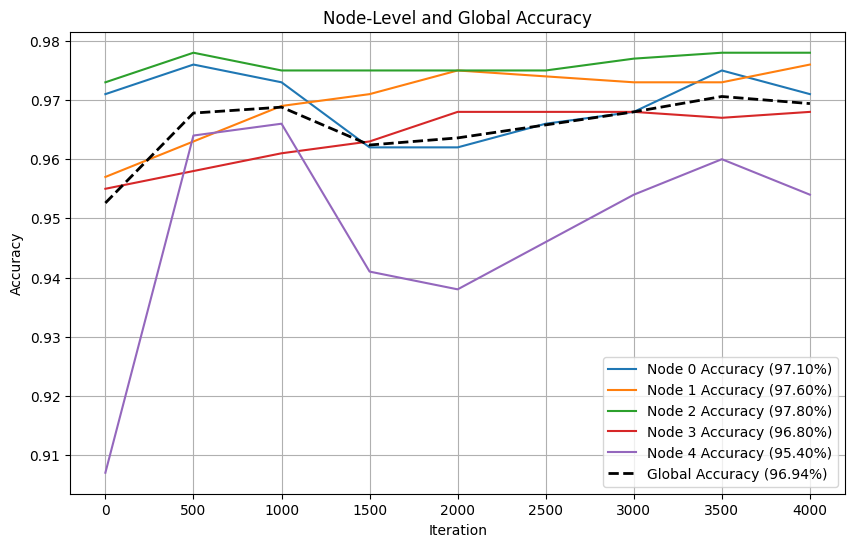

In [113]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load CSV ===
df = pd.read_csv('metrics_log.csv')

# === Plot Node-Level Accuracies with Final Accuracy in Legend ===
plt.figure(figsize=(10, 6))
for node in range(5):  # Update if different
    final_acc = df[f'node_{node}_accuracy'].iloc[-1] * 100
    label = f'Node {node} Accuracy ({final_acc:.2f}%)'
    plt.plot(df['iteration'], df[f'node_{node}_accuracy'], label=label)

# === Plot Global Accuracy with Final Accuracy in Legend ===
final_global_acc = df['global_accuracy'].iloc[-1] * 100
global_label = f'Global Accuracy ({final_global_acc:.2f}%)'
plt.plot(df['iteration'], df['global_accuracy'], label=global_label, color='black', linewidth=2, linestyle='--')

# === Final Plotting ===
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Node-Level and Global Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [114]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np

# === Load Data from All 5 Nodes ===
X_list = []
y_list = []

for node in range(5):
    features = pd.read_csv(f'synthetic_data/node_{node}_features.csv').values.astype(np.float32)
    labels = pd.read_csv(f'synthetic_data/node_{node}_labels.csv').values.astype(np.float32).reshape(-1, 1)
    X_list.append(features)
    y_list.append(labels)

# === Combine Data ===
X_all = np.vstack(X_list)
y_all = np.vstack(y_list)

# === Convert to PyTorch tensors ===
X_tensor = torch.tensor(X_all)
y_tensor = torch.tensor(y_all)

# === Normalize Features (Recommended) ===
X_tensor = (X_tensor - X_tensor.mean(0)) / (X_tensor.std(0) + 1e-6)

# === Dataset and DataLoader ===
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# === Simple Logistic Regression Model ===
model = nn.Sequential(
    nn.Linear(X_tensor.shape[1], 1),
    nn.Sigmoid()
)

# === Loss and Optimizer ===
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# === Training Loop ===
epochs = 1000
for epoch in range(epochs):
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0 or epoch == epochs - 1:
        with torch.no_grad():
            preds = model(X_tensor)
            acc = ((preds > 0.5) == y_tensor).float().mean().item()
            print(f"Epoch {epoch}: Loss={loss.item():.4f}, Accuracy={acc:.4f}")


Epoch 0: Loss=0.7837, Accuracy=0.3047
Epoch 100: Loss=0.0781, Accuracy=0.9852
Epoch 200: Loss=0.0171, Accuracy=0.9858
Epoch 300: Loss=0.1538, Accuracy=0.9862
Epoch 400: Loss=0.0364, Accuracy=0.9864
Epoch 500: Loss=0.0000, Accuracy=0.9866
Epoch 600: Loss=0.0147, Accuracy=0.9864
Epoch 700: Loss=0.3019, Accuracy=0.9866
Epoch 800: Loss=0.0257, Accuracy=0.9866
Epoch 900: Loss=0.0108, Accuracy=0.9868
Epoch 999: Loss=0.0079, Accuracy=0.9866
